## TASK 3 - Scene recognition with Bag of Visual Words

Group Number: 06

### 1 Data import and Preparation

Complete the class ***SceneDataset*** in ***dataset.py*** and load the training and test dataset. (images and class labels)

In [233]:
%load_ext autoreload
%autoreload 1
%aimport features, dataset, utils
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
import numpy as np
import features
import dataset
import utils
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [234]:
if not os.path.exists(os.path.join(os.getcwd(), 'results')):
    os.makedirs(os.path.join(os.getcwd(), 'results'))

#student_code start

import dataset

datasetTrain = dataset.SceneDataset(path="data\\scene\\train")
datasetTest = dataset.SceneDataset(path="data\\scene\\test")

test_images = datasetTest.images
test_labels = datasetTest.labels

train_images = datasetTrain.images
train_labels = datasetTrain.labels

class_names = datasetTrain.class_names

# test_images = np.array(test_images)
# train_images = np.array(train_images)

#student_code end
print('Imported test data: ',len(test_images))
print('Imported training data: ', len(train_images))
print(class_names)


Imported test data:  400
Imported training data:  1600
['bedroom', 'coast', 'forest', 'kitchen', 'livingroom', 'mountain', 'office', 'store', 'street', 'tallbuilding']


###  2 Build Vocabulary and Clusters

Extract SIFT features from the training data using ***features.extract_dsift(..)*** and then utilize the descriptors to generate visual words with ***KMeans(...).fit(...).cluster_centers_*** from ***sklearn.neighbors***. Set the sample size per image at about **100** and a step size around **5**. For cluster size, try a value around **50**. You can adapt the paramater to achieve better results. If clustering takes too long, have a look at the parameters **n_init** and **max_iter** of ***KMeans(...)***.

_***HINT:***_
***KMeans(..)*** expects the features to be a stacked 2D matrix instead of a list (np.vstack(...)).


In [235]:
#student code start

descriptors = features.extract_dsift(train_images, stepsize=7, num_samples=100)
descriptors = np.vstack(descriptors)

kmeans = KMeans(n_clusters=52)
visualWords = kmeans.fit(descriptors).cluster_centers_
#student code end

DSIFT Extraction: 2.5532215998973697  seconds


###  3 Classification

Generat a histogram per image using the centroids. First extract the dense SIFT features of the training set again. This time use a smaller stepsize (eg. 1 or 2) and take all samples.

After, implement ***count_visual_words(..)*** in ***features.py*** to obtain a histogram per image. Build a kNN classifier with ***KNeighborsClassifier(..)*** and fit the the model with the histogram data of the training images and training labels. Set the neighbourhood size to **3**.


In [236]:
#student code start
train_descriptors = features.extract_dsift(train_images, stepsize=2, num_samples=None)

train_histograms = features.count_visual_words(train_descriptors, visualWords)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_histograms, train_labels)
#student code end

DSIFT Extraction: 8.75860229996033  seconds
Counting visual words: 7.339440600015223  seconds


KNeighborsClassifier(n_neighbors=3)

### 4 Evaluation

Examine the accuracy of your model by extracting the dense SIFT points of the test set with the same stepsize as before, generate the histogams and predict the labels of the test set with the previously fitted classifier. Plot your results with ***utils.plot_confusion_matrix(..)***.

_***HINT:***_
Use the methods ***predict(..)*** and ***score(..)*** on the KNN classifier.


***Submission:*** Save the confusion matrix with the KNN score as **task3_accuracy_test_data.png** using ***utils.plot_confusion_matrix(..)***.



DSIFT Extraction: 2.1648596001323313  seconds
Counting visual words: 1.917300899978727  seconds
Accuracy on test set: 43.50%


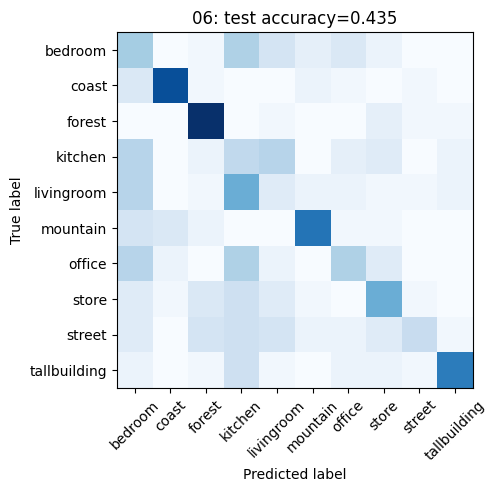

In [237]:
#student code start
test_descriptors = features.extract_dsift(test_images, stepsize=2, num_samples=None)
test_histograms = features.count_visual_words(test_descriptors, visualWords)

predictions = knn.predict(test_histograms)

accuracy = knn.score(test_histograms, test_labels)
print(f"Accuracy on test set: {accuracy * 100:.2f}%")

utils.plot_confusion_matrix(test_labels, predictions, accuracy, class_names, "06", "task3_accuracy_test_data")
#student code end

***
#### Q1: Analyze the confusion matrix. Are there classes which can be more easily identified than others. What could be the reason? What classes perform worst, and explain your answer.


#ANSWER HERE

It appears that the classes where the algorithm performs the best are scenes that have more distinct visual features compared to the rest. Classes like tall buildings, or forests, or a coast are not as easily mixed up. However, for classes like a bedroom, for example, there are quite a few features that might be shared, or be similar, to other closed spaces, like a living room or an office, which explains why that type of classes performs a lot worse and are mixed up a lot of times.


Take some own test images and investigate if they can be correctly classified with you trained model. For instance, take a photo of your own kitchen or living room and classify it. You should at least test one photo from three of the ten categories. Make sure the images are resized and cropped to 100x100.

***Submission:*** Save the confusion matrix with the model score as **task3_accuracy_custom_data.png** using ***utils.plot_confusion_matrix(..)***.

DSIFT Extraction: 0.022110400022938848  seconds
Counting visual words: 0.02490679989568889  seconds
Accuracy on test set: 33.33%
['bedroom', 'coast', 'forest', 'kitchen', 'livingroom', 'mountain', 'office', 'store', 'street', 'tallbuilding']


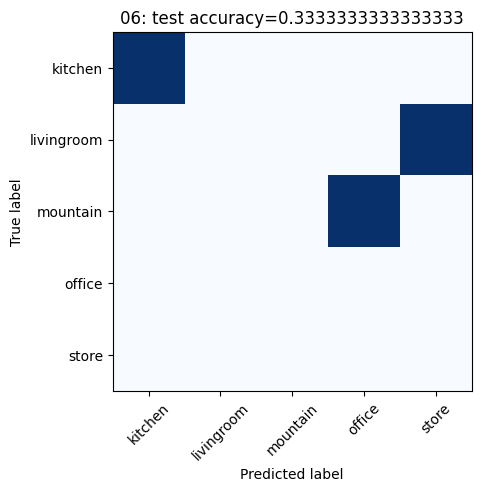

In [238]:
#student code start

customDataset = dataset.SceneDataset(path="data\\custom")
customDescriptors = customDataset.images
customLabels = [3, 4, 5]

customDescriptors = features.extract_dsift(customDescriptors, stepsize=2, num_samples=None)
customHistograms = features.count_visual_words(customDescriptors, visualWords)

predictions = knn.predict(customHistograms)
accuracy = knn.score(customHistograms, customLabels)
print(f"Accuracy on test set: {accuracy * 100:.2f}%")
print(class_names)
utils.plot_confusion_matrix(customLabels, predictions, accuracy, class_names, "06", "task3_accuracy_custom_data")

#student code end

### 5 Beyond Bag Of Words: Vector of Locally Aggregated Descriptors (VLAD)

Finally, we want to investigate an extension of the traditional bag of words model, called **Vector of Locally Aggregated Descriptors (VLAD)**, which not only considers the cluster assignment, but also uses the distance to the nearest centroid (refered to as **residual**).

Implement the VLAD algorithm in **features.calculate_vlad_descriptors** according to the task description and run the whole classification again by replacing the bag of words descriptors with VLAD. Compare the performance and discuss the advantages and disadvantages. Can you think of any further extensions?

***Submission:*** Save the confusion matrix with the model score as **task3_accuracy_vlad_descriptor.png** using ***utils.plot_confusion_matrix(..)***.

Counting visual words: 13.360464799916372  seconds
Counting visual words: 3.3967661999631673  seconds
VLAD Accuracy: 51.00%


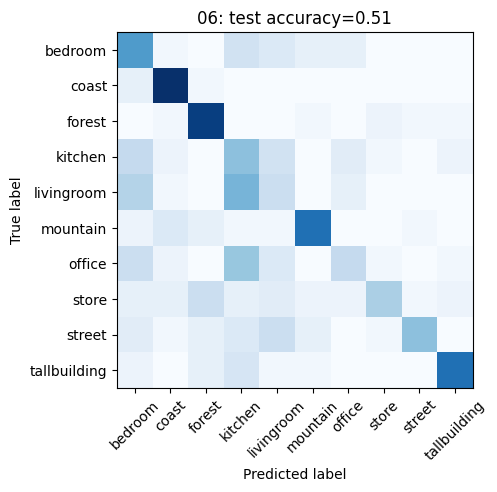

In [239]:
#student code start

train_vlad = features.calculate_vlad_descriptors(train_descriptors, visualWords)
test_vlad = features.calculate_vlad_descriptors(test_descriptors, visualWords)

# Train and evaluate k-NN classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_vlad, train_labels)
accuracy = knn.score(test_vlad, test_labels)

print(f"VLAD Accuracy: {accuracy * 100:.2f}%")

# Confusion matrix
predictions = knn.predict(test_vlad)
utils.plot_confusion_matrix(test_labels, predictions, accuracy, class_names, "06", "task3_accuracy_vlad_descriptor")

#student code end